# SHAP and LIME

***These examples are modified from notebook provided by Domino Data Lab, described in their 14 Aug 2019 webinar.***

Data used here are from the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data) at Kaggle.

<font color='darkgreen'>**As this notebook is lengthy, readers will find it much easier to navigate with [Jupyter Nbextensions](https://github.com/ipython-contrib/jupyter_contrib_nbextensions) installed, and Table of Contents (2) selected:**</font>

**Highlights**

* For the k-nearest neighbors model, computing Shapley values is prohibitive, due to the $\frac{k'(k'-1)}{2}$ distances that must be computed for each permutation of features left out; instead cluster size-weighted k-means values are supplied to `shap.KernelExplainer()`.
* Examples are provided for XGBoost Shapley force plots that generate separate image files that can be inserted into documents.
* Here, we provide a solution to a problem involving the XGBoost `.predict()` medthod. It requires DMatrix inputs, so a wrapper function is invoked when generating LIME plots.
* For XGBoost there are examples of how to export images (PNG files in this case) for both Shapley force plots and LIME bar plots.

**Next two lines are for pretty output for all prints in a Pandas cell, not just the last.**

In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Next two lines are useful in the event of external code changes.**

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import libraries

Import local plotting routines.
The `plotHelpers` module includes `dependencePlot()`, which is a version of `shap.dependence_plot()` modified to allow for particular index values of the data to be overplotted in highlighted form.

>**`dependencePlot()` *not implimented yet***

In [20]:
import sys
# sys.path.append('../../Mlib')
# import plotHelpers as ph

In [21]:
from timeit import default_timer as dtime
from time import time, asctime, gmtime, localtime
print(asctime(localtime()))

t0 = dtime()
import os  #needed to use Environment Variables in Domino
import lime  #LIME package
import lime.lime_tabular  #the type of LIIME analysis we’ll do
from pathlib import Path

print("Python version: ", sys.version_info[:])
print("\nUn-versioned imports:")
print('os', end="")
if 'sys' in sys.modules:
    print(', sys', end="")
if 'timeit' in sys.modules:
    print(', timeit', end="")
if 'time' in sys.modules:
    print(', time', end="")
if 'lime' in sys.modules:
    print(', lime', end="")
if 'pathlib' in sys.modules:
    print(', pathlib', end="")
# if '' in sys.modules:
#     print(', ', end="")

import pandas as pd  #for manipulating data
import numpy as np  #for manipulating data
import sklearn  #for building models
import xgboost as xgb  #for building models
import sklearn.ensemble  #for building models
from sklearn.model_selection import train_test_split  #for creating a hold-out sample
import shap  #SHAP package
from matplotlib import __version__ as mpVersion
import matplotlib.pyplot as plt  #for custom graphs at the end
import seaborn as sns  #for custom graphs at the end
print("\n")
if 'pandas' in sys.modules:
    print(f"pandas: {pd.__version__}", end="\t")
if 'numpy' in sys.modules:
    print(f"numpy: {np.__version__}", end="\t")
if 'sklearn' in sys.modules:
    print(f"sklearn: {sklearn.__version__}", end="\t")
if 'xgboost' in sys.modules:
    print(f"xgboost: {xgb.__version__}", end="\t")
if 'shap' in sys.modules:
    print(f"shap: {shap.__version__}", end="\t")
if 'matplotlib' in sys.modules:
    print(f"matplotlib: {mpVersion}", end="\t")
if 'seaborn' in sys.modules:
    print(f"seaborn: {sns.__version__}", end="\t")
# if '' in sys.modules:
#     print(f": {.__version__}", end="\t")

# %matplotlib inline

Thu Jan  2 14:50:03 2020
Python version:  (3, 7, 5, 'final', 0)

Un-versioned imports:
os, sys, timeit, time, lime, pathlib

pandas: 0.24.2	numpy: 1.17.4	sklearn: 0.21.2	xgboost: 1.0.0-SNAPSHOT	shap: 0.32.1	matplotlib: 3.1.0	seaborn: 0.9.0	

### Set `KMP_DUPLICATE_LIB_OK="TRUE`

This environment variable must be set `True` to keep `xgboost.train()` from killing the Jupyter kernel.

In [22]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Load and explore Breast Cancer Wisconsin (Diagnostic) Data

### Get the data

In [23]:
cwd = Path.cwd()
df = pd.read_csv(cwd / 'data.csv')
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,842302,842517,84300903,84348301,84358402,843786,844359,84458202,844981,84501001
diagnosis,M,M,M,M,M,M,M,M,M,M
radius_mean,17.99,20.57,19.69,11.42,20.29,12.45,18.25,13.71,13,12.46
texture_mean,10.38,17.77,21.25,20.38,14.34,15.7,19.98,20.83,21.82,24.04
perimeter_mean,122.8,132.9,130,77.58,135.1,82.57,119.6,90.2,87.5,83.97
area_mean,1001,1326,1203,386.1,1297,477.1,1040,577.9,519.8,475.9
smoothness_mean,0.1184,0.08474,0.1096,0.1425,0.1003,0.1278,0.09463,0.1189,0.1273,0.1186
compactness_mean,0.2776,0.07864,0.1599,0.2839,0.1328,0.17,0.109,0.1645,0.1932,0.2396
concavity_mean,0.3001,0.0869,0.1974,0.2414,0.198,0.1578,0.1127,0.09366,0.1859,0.2273
concave points_mean,0.1471,0.07017,0.1279,0.1052,0.1043,0.08089,0.074,0.05985,0.09353,0.08543


### binarize the `diagnosis` variable

In [24]:
df['diagnosis'] = df.diagnosis.apply(lambda s: 0 if s == 'B' else 1)
df['diagnosis'] = df.diagnosis.astype(np.int8)
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,842302.000000,842517.000000,8.430090e+07,8.434830e+07,8.435840e+07,843786.000000,844359.000000,8.445820e+07,844981.000000,8.450100e+07
diagnosis,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
radius_mean,17.990000,20.570000,1.969000e+01,1.142000e+01,2.029000e+01,12.450000,18.250000,1.371000e+01,13.000000,1.246000e+01
texture_mean,10.380000,17.770000,2.125000e+01,2.038000e+01,1.434000e+01,15.700000,19.980000,2.083000e+01,21.820000,2.404000e+01
perimeter_mean,122.800000,132.900000,1.300000e+02,7.758000e+01,1.351000e+02,82.570000,119.600000,9.020000e+01,87.500000,8.397000e+01
area_mean,1001.000000,1326.000000,1.203000e+03,3.861000e+02,1.297000e+03,477.100000,1040.000000,5.779000e+02,519.800000,4.759000e+02
smoothness_mean,0.118400,0.084740,1.096000e-01,1.425000e-01,1.003000e-01,0.127800,0.094630,1.189000e-01,0.127300,1.186000e-01
compactness_mean,0.277600,0.078640,1.599000e-01,2.839000e-01,1.328000e-01,0.170000,0.109000,1.645000e-01,0.193200,2.396000e-01
concavity_mean,0.300100,0.086900,1.974000e-01,2.414000e-01,1.980000e-01,0.157800,0.112700,9.366000e-02,0.185900,2.273000e-01
concave points_mean,0.147100,0.070170,1.279000e-01,1.052000e-01,1.043000e-01,0.080890,0.074000,5.985000e-02,0.093530,8.543000e-02


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null int8
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-n

In [26]:
df.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,86210.040000,90267.000000,853155.400000,869218.000000,906024.000000,8.813129e+06,8.814422e+07,9.042446e+07,9.010343e+08,9.113205e+08
diagnosis,569.0,3.725835e-01,4.839180e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,8.458360,9.529200,10.260000,11.700000,13.370000,1.578000e+01,1.953000e+01,2.057600e+01,2.437160e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,10.930400,13.088000,14.078000,16.170000,18.840000,2.180000e+01,2.499200e+01,2.715000e+01,3.065200e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,53.827600,60.496000,65.830000,75.170000,86.240000,1.041000e+02,1.291000e+02,1.358200e+02,1.657240e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,215.664000,275.780000,321.600000,420.300000,551.100000,7.827000e+02,1.177400e+03,1.309800e+03,1.786600e+03,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.068654,0.075042,0.079654,0.086370,0.095870,1.053000e-01,1.148200e-01,1.187800e-01,1.328880e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.033351,0.040660,0.049700,0.064920,0.092630,1.304000e-01,1.754600e-01,2.087000e-01,2.771920e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.000000,0.004983,0.013686,0.029560,0.061540,1.307000e-01,2.030400e-01,2.430200e-01,3.516880e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.000000,0.005621,0.011158,0.020310,0.033500,7.400000e-02,1.004200e-01,1.257400e-01,1.642080e-01,2.012000e-01


### Test-Train Split

#### Start by initializing a random.randomState object

In [27]:
myRandomState = np.random.RandomState(21)

#### Split, applying randomState

In [28]:
dfX = df.loc[:, 'radius_mean':'fractal_dimension_worst']
dfy = df['diagnosis']

dfXtrain, dfXtest, dfyTrain, dfyTest = \
    train_test_split(dfX, dfy, test_size=0.2, random_state=myRandomState, stratify=dfy)
dfXtrain.head(5).T
dfXtest.head(5).T

,516,305,214,327,495
radius_mean,18.310000,11.600000,14.190000,12.030000,14.870000
texture_mean,20.580000,24.490000,23.810000,17.930000,20.210000
perimeter_mean,120.800000,74.230000,92.870000,76.090000,96.120000
area_mean,1052.000000,417.200000,610.700000,446.000000,680.900000
smoothness_mean,0.106800,0.074740,0.094630,0.076830,0.095870
compactness_mean,0.124800,0.056880,0.130600,0.038920,0.083450
concavity_mean,0.156900,0.019740,0.111500,0.001546,0.068240
concave points_mean,0.094510,0.013130,0.064620,0.005592,0.049510
symmetry_mean,0.186000,0.193500,0.223500,0.138200,0.148700
fractal_dimension_mean,0.059410,0.058780,0.064330,0.060700,0.057480


,255,2,29,243,282
radius_mean,13.960000,19.690000,17.570000,13.750000,19.400000
texture_mean,17.050000,21.250000,15.050000,23.770000,18.180000
perimeter_mean,91.430000,130.000000,115.000000,88.540000,127.200000
area_mean,602.400000,1203.000000,955.100000,590.000000,1145.000000
smoothness_mean,0.109600,0.109600,0.098470,0.080430,0.103700
compactness_mean,0.127900,0.159900,0.115700,0.068070,0.144200
concavity_mean,0.097890,0.197400,0.098750,0.046970,0.162600
concave points_mean,0.052460,0.127900,0.079530,0.023440,0.094640
symmetry_mean,0.190800,0.206900,0.173900,0.177300,0.189300
fractal_dimension_mean,0.061300,0.059990,0.061490,0.054290,0.058920


## It's model time

Will apply
* xgboost
* random forest
* KNN

### XGBoost

In [47]:
xgb_model = xgb.train({"learning_rate": 0.01, 'objective': 'binary:logistic'}, xgb.DMatrix(dfXtrain, label=dfyTrain), 100)

### Gradient boosted trees from scikit-learn

In [30]:
skXGB = sklearn.ensemble.GradientBoostingClassifier()
skXGB.fit(dfXtrain, dfyTrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Random Forest

In [31]:
RF = sklearn.ensemble.RandomForestClassifier(n_estimators=30)
RF.fit(dfXtrain, dfyTrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### K Nearest Neighbors

In [32]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(dfXtrain, dfyTrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

## Shapley explainers

### XGBoost

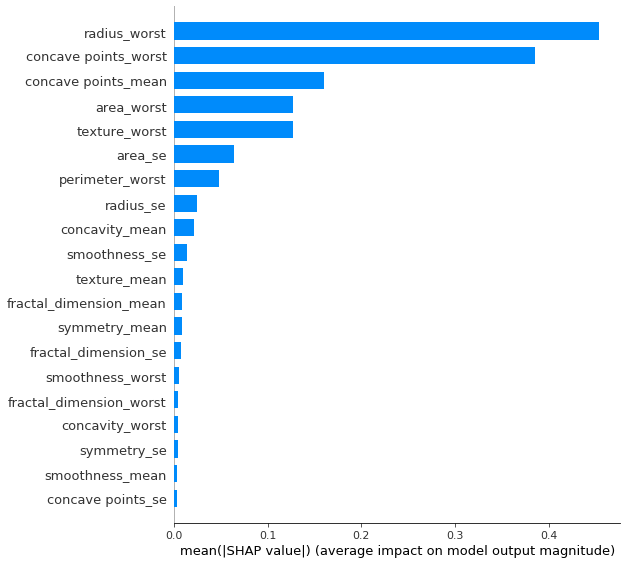

In [49]:
explainerXGB = shap.TreeExplainer(xgb_model)
shapValuesXGBtest = explainerXGB.shap_values(dfXtest)
shapValuesXGBtrain = explainerXGB.shap_values(dfXtrain)
shap.summary_plot(shapValuesXGBtrain, dfXtrain, plot_type="bar")

### Gradient boosted trees, sklearn

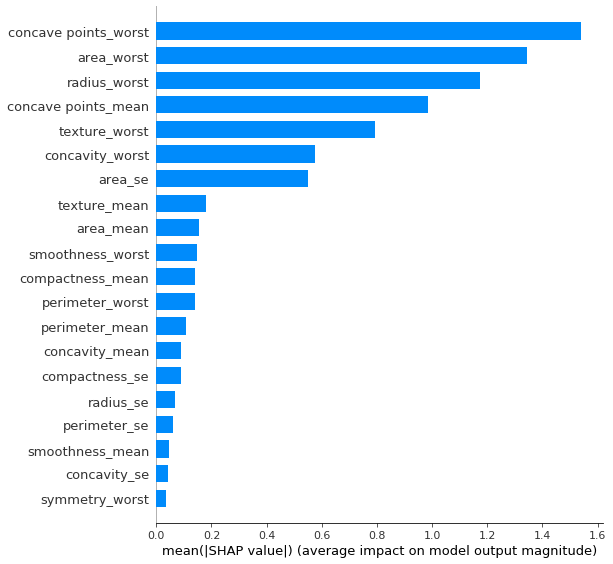

In [46]:
explainerSKGBT = shap.TreeExplainer(skXGB)
shapValuesSKGBTtest = explainerSKGBT.shap_values(dfXtest)
shapValuesSKGBTtrain = explainerSKGBT.shap_values(dfXtrain)
shap.summary_plot(shapValuesSKGBTtrain, dfXtrain, plot_type="bar")

### Random Forest

(2, 114, 30)
(2, 455, 30)


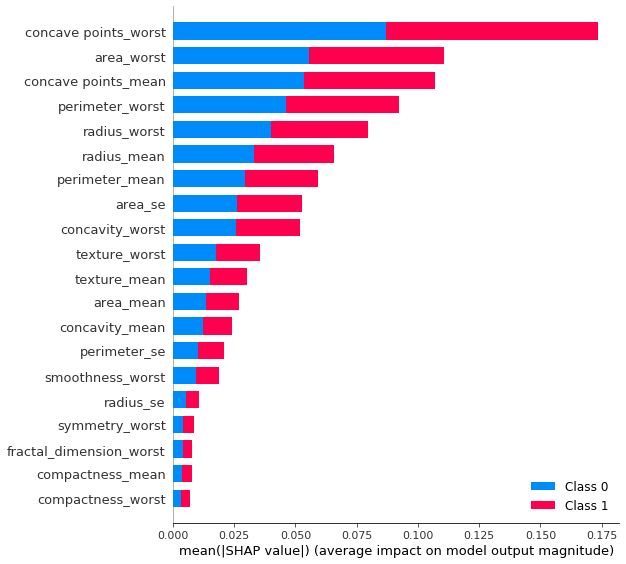

In [45]:
explainerRF = shap.TreeExplainer(RF)
shapValuesRFtest = explainerRF.shap_values(dfXtest)
print(np.shape(shapValuesRFtest))
shapValuesRFtrain = explainerRF.shap_values(dfXtrain)
print(np.shape(shapValuesRFtrain))
shap.summary_plot(shapValuesRFtrain, dfXtrain, plot_type="bar")

In [44]:
dfXtest.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
255,13.96,17.05,91.43,602.4,0.10960,0.12790,0.09789,0.05246,0.1908,0.06130,...,16.39,22.07,108.1,826.0,0.15120,0.3262,0.3209,0.13740,0.3068,0.07957
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.14440,0.4245,0.4504,0.24300,0.3613,0.08758
29,17.57,15.05,115.00,955.1,0.09847,0.11570,0.09875,0.07953,0.1739,0.06149,...,20.01,19.52,134.9,1227.0,0.12550,0.2812,0.2489,0.14560,0.2756,0.07919
243,13.75,23.77,88.54,590.0,0.08043,0.06807,0.04697,0.02344,0.1773,0.05429,...,15.01,26.34,98.0,706.0,0.09368,0.1442,0.1359,0.06106,0.2663,0.06321
282,19.40,18.18,127.20,1145.0,0.10370,0.14420,0.16260,0.09464,0.1893,0.05892,...,23.79,28.65,152.4,1628.0,0.15180,0.3749,0.4316,0.22520,0.3590,0.07787


### KNN

* Processing is way too slow for KNN, unless steps are taken to summarize the data
* Here the strategy is to us k-Means

Rather than use the whole training set to estimate expected values, we summarize with a set of weighted kmeans, each weighted by the number of points they represent.
Running without the kmeans took 1 hr 6 mins 7 sec. 
Running with the kmeans took 2 min 47 sec.
Boston Housing is a very small dataset.
Running SHAP on models that require Kernel method and have a good amount of data becomes prohibitive.

#### Get them k-Means-summarized training datums

In [36]:
help(shap.kmeans)

Help on function kmeans in module shap.explainers.kernel:

kmeans(X, k, round_values=True)
    Summarize a dataset with k mean samples weighted by the number of data points they
    each represent.
    
    Parameters
    ----------
    X : numpy.array or pandas.DataFrame
        Matrix of data samples to summarize (# samples x # features)
    
    k : int
        Number of means to use for approximation.
    
    round_values : bool
        For all i, round the ith dimension of each mean sample to match the nearest value
        from X[:,i]. This ensures discrete features always get a valid value.
    
    Returns
    -------
    DenseData object.



In [37]:
XtrainSummary = shap.kmeans(dfXtrain, 10)

#### Extract Shapley values using the k-means summarized training datums

Step takes ~14 mins.

In [38]:
t0 = dtime()
explainerKNN = shap.KernelExplainer(knn.predict, XtrainSummary)
shapValuesKNNtrain = explainerKNN.shap_values(dfXtrain)
shapValuesKNNtest = explainerKNN.shap_values(dfXtest)
t1 = dtime()
Δt = t1 - t0
print(f"Δt: {int(Δt//60): 2d}m, {Δt % 60.0: 4.1f}s")

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo

/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/lo


Δt:  14m,  13.2s


/usr/local/lib64/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


## Get the SHAP values into dataframes so we can use them later on

### XGBoost

In [39]:
dfShapXGBtrain = pd.DataFrame(shapValuesXGBtrain, columns=dfXtrain.columns.values)
dfShapXGBtest = pd.DataFrame(shapValuesXGBtest, columns=dfXtest.columns.values)

### Gradient boosted trees, sklearn

In [40]:
dfShapSKGBTtrain = pd.DataFrame(shapValuesSKGBTtrain, columns=dfXtrain.columns.values)
dfShapSKGBTtest = pd.DataFrame(shapValuesSKGBTtest, columns=dfXtest.columns.values)

### Random Forest

In [42]:
np.shape(shapValuesSKGBTtrain), np.shape(dfXtrain.columns.values), np.shape(shapValuesRFtrain), np.shape(dfXtrain.columns.values)

((455, 30), (30,), (2, 455, 30), (30,))

In [41]:
dfShapRFtrain = pd.DataFrame(shapValuesRFtrain, columns=dfXtrain.columns.values)
dfShapRFtest = pd.DataFrame(shapValuesRFtest, columns=dfXtest.columns.values)

ValueError: Must pass 2-d input

### KNN

In [ ]:
dfShapKNNtrain = pd.DataFrame(shapValuesKNNtrain, columns=dfXtrain.columns.values)
dfShapKNNtest = pd.DataFrame(shapValuesKNNtest, columns=dfXtest.columns.values)

## LIME explainers

* If a feature has 10 or fewer unique values, treat as if it is categorical

In [ ]:
categoricalFeatures = np.argwhere(np.array([len(set(dfXtrain.values[:,x]))
                                            for x in range(dfXtrain.values.shape[1])]) <= 10).flatten()

* Lime has one explainer for all models

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(dfXtrain.values, 
                                                   feature_names=dfXtrain.columns.values.tolist(), 
                                                   class_names=['diagnosis'], 
                                                   categorical_features=categoricalFeatures, 
                                                   verbose=True, 
                                                   mode='regression')

## Local interpretability (explaining single instances)

* Below, `j` is an instance to examine &mdash; picked randomly here
* shap `force_plot`s are generated by JavaScript, but if you insert arguments `show=False, matplotlib=True` (single instances only), the plotting is handled by matplotlib; append `.savefig(<figname>)` to create plot files for use elsewhere. *This seems to have an added bonus of making better use of available horizontal space.*

In [ ]:
np.random.seed(5)
j = np.random.randint(0, dfXtest.shape[0])

#### Initialize Javascript

* The `shap` package uses javascript for plots ...

In [ ]:
shap.initjs()

### XGBoost

#### Shapley

In [ ]:
shap.force_plot(explainerXGB.expected_value, shapValuesXGBtest[j], dfXtest.iloc[[j]])

In [ ]:
shap.force_plot(explainerXGB.expected_value, shapValuesXGBtest[j-20], dfXtest.iloc[[j-20]])

#### LIME

* Out-of-the-box LIME cannot handle the requirement of XGBoost to use xgb.DMatrix() on the input data.
* The predict function is inconsistent with it ...

$\longrightarrow$ create a wrapper function to insert the data into a DMatrix

In [ ]:
xgb_model.predict(xgb.DMatrix(dfXtest.iloc[[j]]))
feature_names = xgb.DMatrix(dfXtest.iloc[[j]])._feature_names

##### Wrapper function `wrappedPredict()`

The lime package's `explainer.explain_instance()` method wants the input to be an ndarray, but the `xgb_model.predict()` method wants a DMatrix. To fix this, supply a wrapper for `.predict()` that takes the regular ndarray and creates the DMatrix before the predict.

This function follows the wrappers described in [how to use lime with xgboost? #334](https://github.com/marcotcr/lime/issues/334).

In [ ]:
def wrappedPredict(Xj):
    '''
    wrap xgboost predict function in order to make it lime-friendly
    xgb_model and feature_names are defined outside
    '''

    yDummy = np.array([ 1 for _ in range(Xj.shape[0]) ])
    XDMatrix = xgb.DMatrix(Xj, yDummy, feature_names=feature_names)

    return xgb_model.predict(XDMatrix)

In [ ]:
expXGB = explainer.explain_instance(dfXtest.values[j], wrappedPredict, num_features=5)
expXGB.show_in_notebook(show_table=True)

In [ ]:
expXGB = explainer.explain_instance(dfXtest.values[j - 20], wrappedPredict, num_features=5)
expXGB.show_in_notebook(show_table=True)

### Gradient boosted trees, sklearn

#### Shapley

In [ ]:
shap.force_plot(explainerSKGBT.expected_value, shapValuesSKGBTtest[j], dfXtest.iloc[[j]])

In [ ]:
shap.force_plot(explainerSKGBT.expected_value, shapValuesSKGBTtest[j-20], dfXtest.iloc[[j-20]])

##### Save a copies as a PNG files

Note that the `bbox_inches='tight'` argument to `.savefig()` is needed to prevent cropping of title.

In [ ]:
shap.force_plot(explainerSKGBT.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]],
                show=False, matplotlib=True).savefig('ForcePlotSKGBTj.png', bbox_inches='tight')

In [ ]:
shap.force_plot(explainerSKGBT.expected_value, shap_values_XGB_test[j - 20], X_test.iloc[[j - 20]],
                show=False, matplotlib=True).savefig('ForcePlotSKGBTjm20.png', bbox_inches='tight')

#### LIME

In [ ]:
expSKGBT = explainer.explain_instance(X_test.values[j], skXGB.predict, num_features=5)
expSKGBT.show_in_notebook(show_table=True)

##### Create bar plot as PNG file

**Important:**

* Each invocation of `.explain_instance()` makes calls to `np.random`; do not call again if you want the saved image file to look like the in-line example above
* Only shows center of figure above
* Unfortunately, `.as_pyplot_figure()` seems to use 'classic' matplotlib 'r' and 'g' colors, instead of the v2.0 colors '#1f77b4' and '#FF7F0E'.
  * To get around this, painfully, you can alter the result on the command line with ImageMagick:
```bash
convert LIMEbarplotXGBbadCols.png -fuzz 15% -fill "#1F77B4" -opaque "#FF0000" tmp.png
convert tmp.png  -fuzz 15% -fill "#FF7F0E" -opaque "#008000" LIMEbarplotXGB.png
rm -f LIMEbarplotXGBbadCols.png tmp.png
```

Below, this conversion is done in-line using '!'.

In [ ]:
# expXGB = explainer.explain_instance(X_test.values[j], wrappedPredict, num_features=5)
fig = expSKGBT.as_pyplot_figure()
fig.savefig('LIMEbarplotXGBbadCols.png', bbox_inches='tight')

In [ ]:
!convert LIMEbarplotXGBbadCols.png -fuzz 15% -fill "#1F77B4" -opaque "#FF0000" tmp.png
!convert tmp.png  -fuzz 15% -fill "#FF7F0E" -opaque "#008000" LIMEbarplotOnlySKGBT.png
!rm -f LIMEbarplotXGBbadCols.png tmp.png

In [ ]:
expSKGBT = explainer.explain_instance(X_test.values[j - 20], skXGB.predict, num_features=5)
expSKGBT.show_in_notebook(show_table=True)

In [ ]:
# expXGB = explainer.explain_instance(X_test.values[j], wrappedPredict, num_features=5)
fig = expSKGBT.as_pyplot_figure()
fig.savefig('LIMEbarplotSKGBTbadCols.png', bbox_inches='tight')

In [ ]:
!convert LIMEbarplotSKGBTbadCols.png -fuzz 15% -fill "#1F77B4" -opaque "#FF0000" tmp.png
!convert tmp.png  -fuzz 15% -fill "#FF7F0E" -opaque "#008000" LIMEbarplotOnlySKGBTjm20.png
!rm -f LIMEbarplotSKGBTbadCols.png tmp.png

### Random Forest

#### Shapley

In [ ]:
shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], X_test.iloc[[j]])

In [ ]:
shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j-20], X_test.iloc[[j-20]])

#### LIME

In [ ]:
exp = explainer.explain_instance(X_test.values[j], RF.predict, num_features=5)
exp.show_in_notebook(show_table=True)

### KNN

#### Shapley

**Note:** for reasons that remain unclear, the expected value for KNN needs to be coerced from a scalar ndarray to a float to avoid a `TypeError: len() of unsized object`.

In [ ]:
shap.force_plot(float(explainerKNN.expected_value), shap_values_KNN_test[j], X_test.iloc[[j]])

In [ ]:
shap.force_plot(float(explainerKNN.expected_value), shap_values_KNN_test[j-20], X_test.iloc[[j-20]])

#### LIME

In [ ]:
exp = explainer.explain_instance(X_test.values[j], knn.predict, num_features=5)
exp.show_in_notebook(show_table=True)

## Explaining the global model

### Feature importance using Shapley values

#### As bar plot

 *For some reason, it seems necessary to call* `shap.summary_plot()`* twice. Information from other plots is retained and displayed prior to showing the feature importance plot on the first call.*

In [ ]:
shap.summary_plot(shap_values_SKGBT_train, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values_SKGBT_train, X_train, plot_type="bar")

#### Impact for each instance, for each feature

In [ ]:
shap.summary_plot(shap_values_SKGBT_train, X_train)

### Variable influence / Dependency plots

#### Default

* scatter plots showing the Shapley value vs. the selected feature value
* the `interaction_index` (default: 'auto') is used to pick the feature determining the color (and hence the colorbar) for the point.
* if `interaction_index='auto'`, `shap_values_<model>_train` is used to determine that which interacts most with the specified feature.

In [ ]:
impColumns = df_shap_SKGBT_train.abs().mean().sort_values(ascending=False).index.tolist()

figure, ax = plt.subplots(1, 1)
shp_plt = shap.dependence_plot("LSTAT", shap_values_SKGBT_train, X_train, ax=ax)

In [ ]:
shp_plt = shap.dependence_plot("RM", shap_values_SKGBT_train, X_train)

In [ ]:
shp_plt = shap.dependence_plot("PTRATIO", shap_values_SKGBT_train, X_train)

In [ ]:
shp_plt = shap.dependence_plot("DIS", shap_values_SKGBT_train, X_train)

#### Feature highligting version

First, a helper function `dependencePlot()` is defined to replicate the plots, but allowing for the specific point to be highlighted.

In [ ]:
# ph.dependencePlot("LSTAT", shap_values_SKGBT_train, X_train)